# Statement

The goal is to train a model to automatically detect negative reviews, using a dataset of IMBD movie reviews with polarity labelling and F1 score metric.

# Table of contents

[Init](#Init)

[Load data](#Load-data)

[Preprocessing](#Preprocessing)

[Analysis](#Analysis)

[EDA](#EDA)

[Evaluation Procedure](#Evaluation-Procedure)

[Normalization](#Normalization)

[Train / Test Split](#Train-/-Test-Split)

[Model 0 - Constant](#Model-0---Constant)

[Model 1 - NLTK, TF-IDF and LR](#Model-1---NLTK,-TF-IDF-and-LR)

[Model 2 - spaCy, TF-IDF and LR](#Model-2---spaCy,-TF-IDF-and-LR)

[Model 3 - spaCy, TF-IDF and LGBMClassifier](#Model-3---spaCy,-TF-IDF-and-LGBMClassifier)

[Model 4 - spaCy, TF-IDF and CatBoost](#Model-4---spaCy,-TF-IDF-and-CatBoost)

[My Reviews](#My-Reviews)

[Model 1](#Model-1)

[Model 2](#Model-2)

[Model 3](#Model-3)

[Model 4](#Model-4)

[Conclusions](#Conclusions)

# Init

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Preprocessing

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [6]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

There are 2 entries with nulls that we can remove.

In [7]:
df_reviews = df_reviews.dropna()

In [8]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


df_reviews.describe()

In [9]:
df_reviews['end_year'].unique()

array(['\\N', '1999', '2008', '2005', '1987', '1981', '1990', '2009',
       '1985', '1986', '2004', '2002', '1994', '2007', '1996', '1960',
       '2000', '2012', '2010', '2013', '1980', '2003', '2001', '2011',
       '1978', '2006', '1973', '2017', '1997', '1998', '1984', '1983',
       '1995', '1974', '1970', '1989', '2020', '1988', '1979', '1993',
       '2018', '1977', '1968', '2014', '1975', '1962', '1972', '1976',
       '2016', '1955', '1965', '1982', '1961', '1991', '1969', '1966',
       '1957', '2019', '1953', '1959'], dtype=object)

In [10]:
df_reviews[df_reviews['end_year']=='\\N'].shape

(45050, 17)

column "end_year" is missing for 95% of the entries so it can be removed from data.

In [11]:
df_reviews = df_reviews.drop('end_year', axis=1)

In [12]:
df_reviews['runtime_minutes'].unique()

array(['121', '25', '88', '85', '90', '113', '96', '99', '43', '82', '74',
       '100', '95', '129', '60', '92', '98', '104', '94', '116', '102',
       '141', '89', '120', '180', '97', '107', '87', '44', '149', '130',
       '40', '45', '84', '30', '\\N', '70', '126', '110', '93', '80',
       '78', '8', '118', '123', '106', '79', '109', '112', '139', '117',
       '46', '135', '31', '12', '1', '72', '58', '77', '150', '7', '101',
       '91', '138', '10', '108', '105', '61', '69', '152', '47', '65',
       '23', '119', '374', '225', '66', '71', '15', '114', '83', '20',
       '301', '216', '148', '155', '251', '67', '177', '103', '62', '81',
       '111', '140', '125', '122', '124', '76', '146', '42', '50', '400',
       '73', '115', '75', '200', '22', '133', '160', '86', '21', '128',
       '230', '29', '162', '127', '147', '53', '13', '151', '9', '278',
       '179', '63', '137', '59', '165', '1140', '263', '54', '143', '183',
       '131', '51', '157', '132', '64', '57', '11', '4

In [13]:
df_reviews[df_reviews['runtime_minutes']=='\\N'].shape

(486, 16)

columns "runtime_minutes" is missing for only 1% of entries, we can change to nulls and impute them

In [14]:
df_reviews.loc[df_reviews['runtime_minutes']=='\\N', 'runtime_minutes'] = np.nan
df_reviews.loc[:,'runtime_minutes'] = df_reviews.loc[:,'runtime_minutes'].astype('float64')

In [15]:
df_reviews['sp'].unique()

array(['neg', 'pos'], dtype=object)

"sp" column can be removed as it is alreasy encoded to integers in the target column "pos"

In [16]:
df_reviews = df_reviews.drop('sp', axis=1)

In [17]:
df_reviews['idx'].nunique()

12500

Encoding genre column as one hot:

In [18]:
x=df_reviews.genres.str.split(r',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')

In [19]:
genre_df = pd.get_dummies(x, prefix='genre', columns=['genre']).groupby(level=0).sum()

In [20]:
df_reviews = pd.concat([df_reviews.drop('genres', axis=1), genre_df], axis=1)

Imputing missing values in "runtime_minutes" with mean value:

In [21]:
runtime_minutes_mean = df_reviews.loc[df_reviews['ds_part']=="train", 'runtime_minutes'].mean()
df_reviews.loc[:, 'runtime_minutes'] = df_reviews.loc[:, 'runtime_minutes'].fillna(runtime_minutes_mean)

In [22]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 43 columns):
tconst               47329 non-null object
title_type           47329 non-null object
primary_title        47329 non-null object
original_title       47329 non-null object
start_year           47329 non-null int64
runtime_minutes      47329 non-null float64
is_adult             47329 non-null int64
average_rating       47329 non-null float64
votes                47329 non-null Int64
review               47329 non-null object
rating               47329 non-null int64
pos                  47329 non-null int64
ds_part              47329 non-null object
idx                  47329 non-null int64
genre_Action         47329 non-null uint8
genre_Adult          47329 non-null uint8
genre_Adventure      47329 non-null uint8
genre_Animation      47329 non-null uint8
genre_Biography      47329 non-null uint8
genre_Comedy         47329 non-null uint8
genre_Crime          47329 non-null uint8

# Analysis

In [23]:
cor = df_reviews.corr()
cor[cor>0.2].dropna(axis=0, thresh=2).dropna(axis=1,thresh=2)

,runtime_minutes,is_adult,average_rating,votes,rating,pos,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Crime,genre_Drama,genre_Film-Noir,genre_Game-Show,genre_History,genre_News,genre_Reality-TV,genre_Talk-Show
runtime_minutes,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242073,NaN,NaN,NaN,NaN,NaN,NaN
is_adult,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.930404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_rating,NaN,NaN,1.000000,0.22957,0.509180,0.481103,NaN,NaN,NaN,NaN,NaN,NaN,0.302331,NaN,NaN,NaN,NaN,NaN,NaN
votes,NaN,NaN,0.229570,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,NaN,NaN,0.509180,NaN,1.000000,0.941229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,NaN,NaN,0.481103,NaN,0.941229,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre_Action,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.263024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre_Adult,NaN,0.930404,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre_Adventure,NaN,NaN,NaN,NaN,NaN,NaN,0.263024,NaN,1.000000,0.233142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre_Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233142,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The target column "pos" is highly correlated (0.94) with "rating" column and it might be a problem to use it as a feature.

No other pair of columns with strong dependency.

## EDA

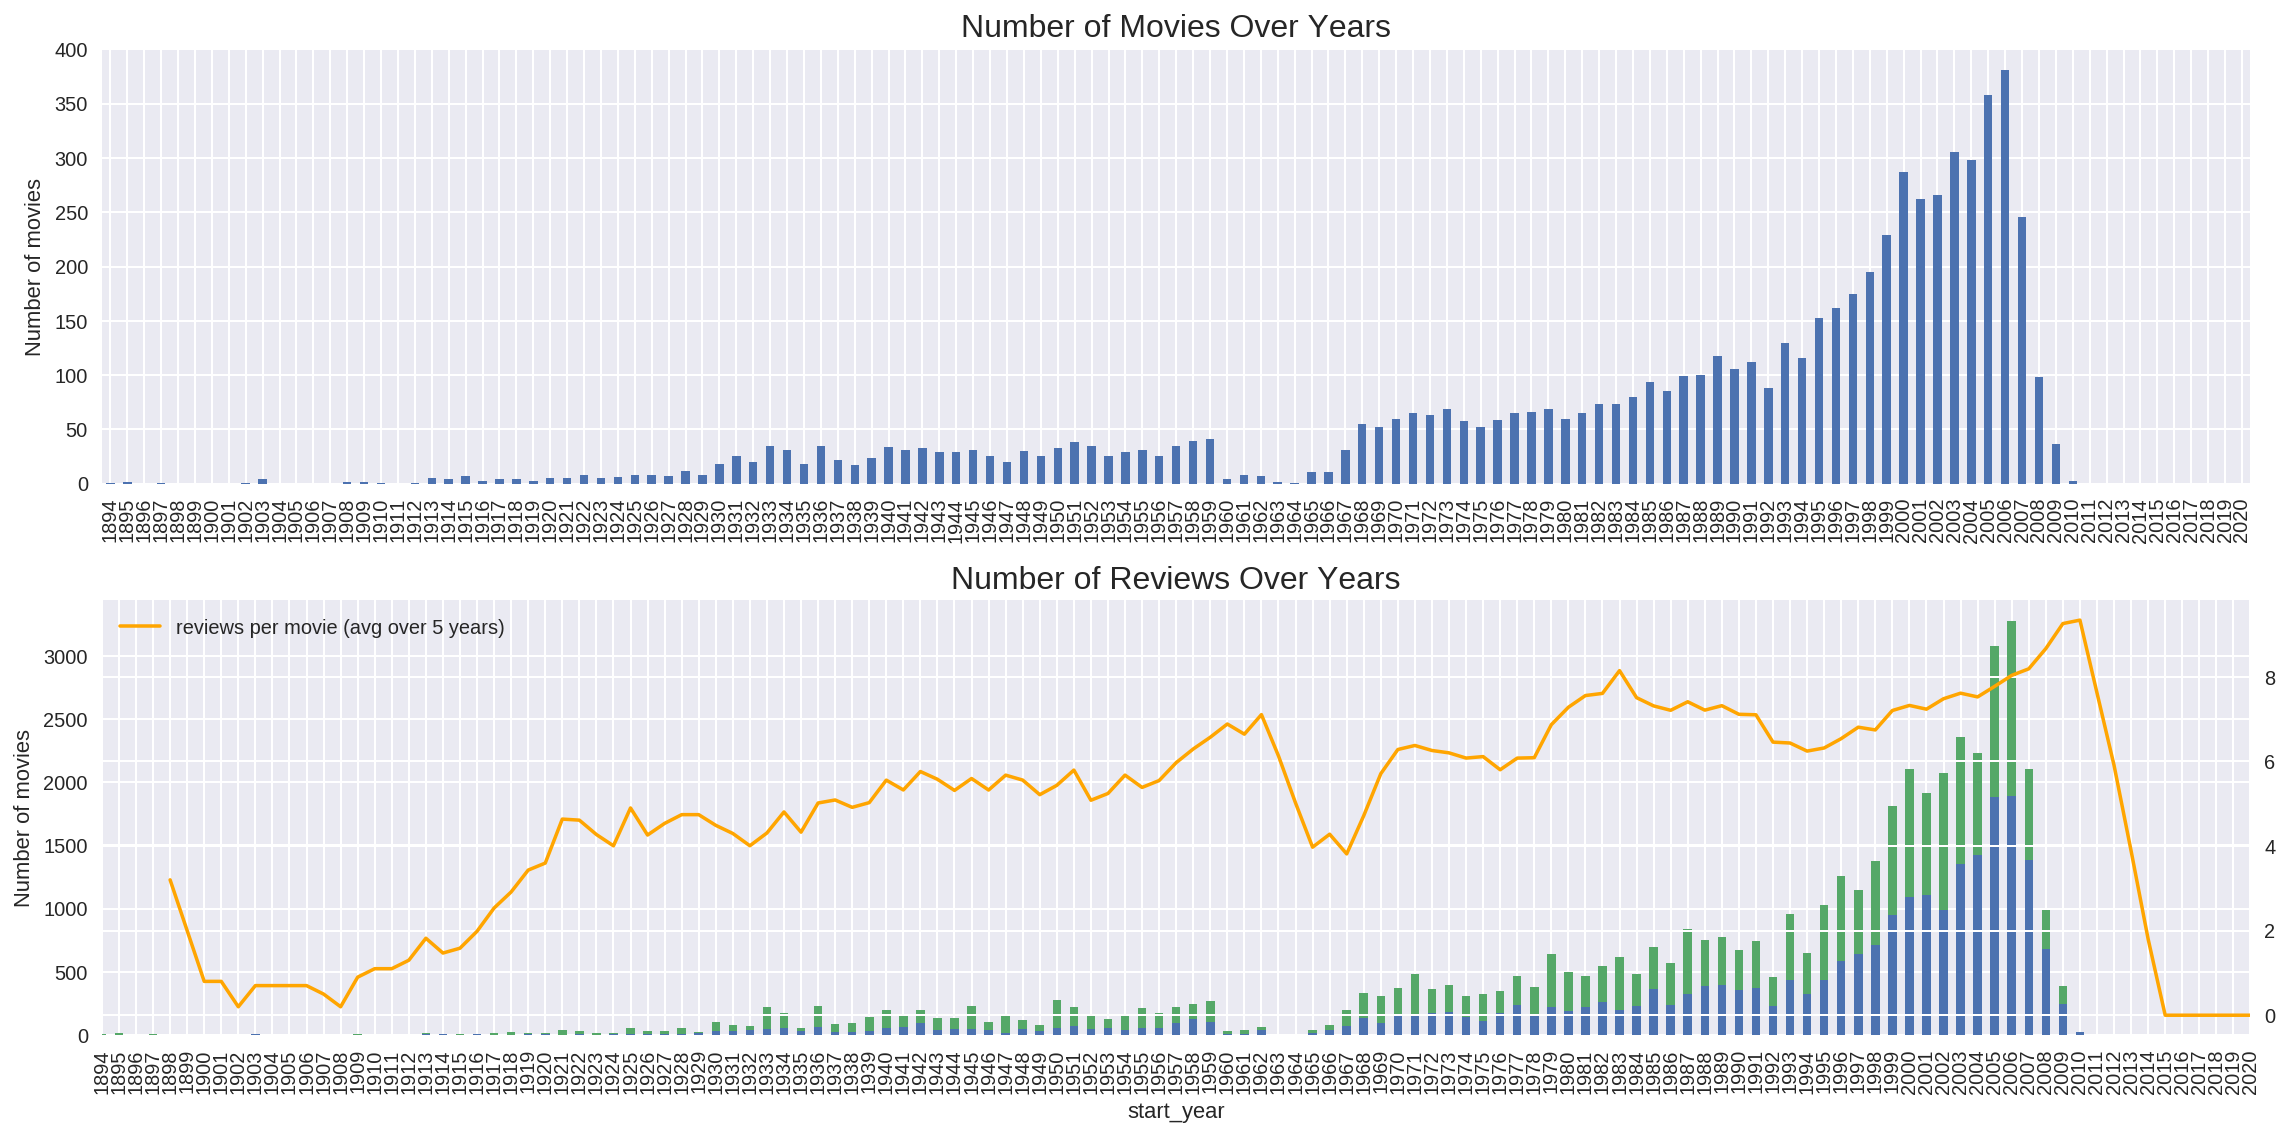

In [26]:
#Number of movies and reviews over the years
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years', fontsize=16)
ax.set_ylabel('Number of movies')
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years', fontsize=16)
ax.set_ylabel('Number of movies')
fig.tight_layout()

Distribution of number of reviews per movie with the exact counting and KDE:

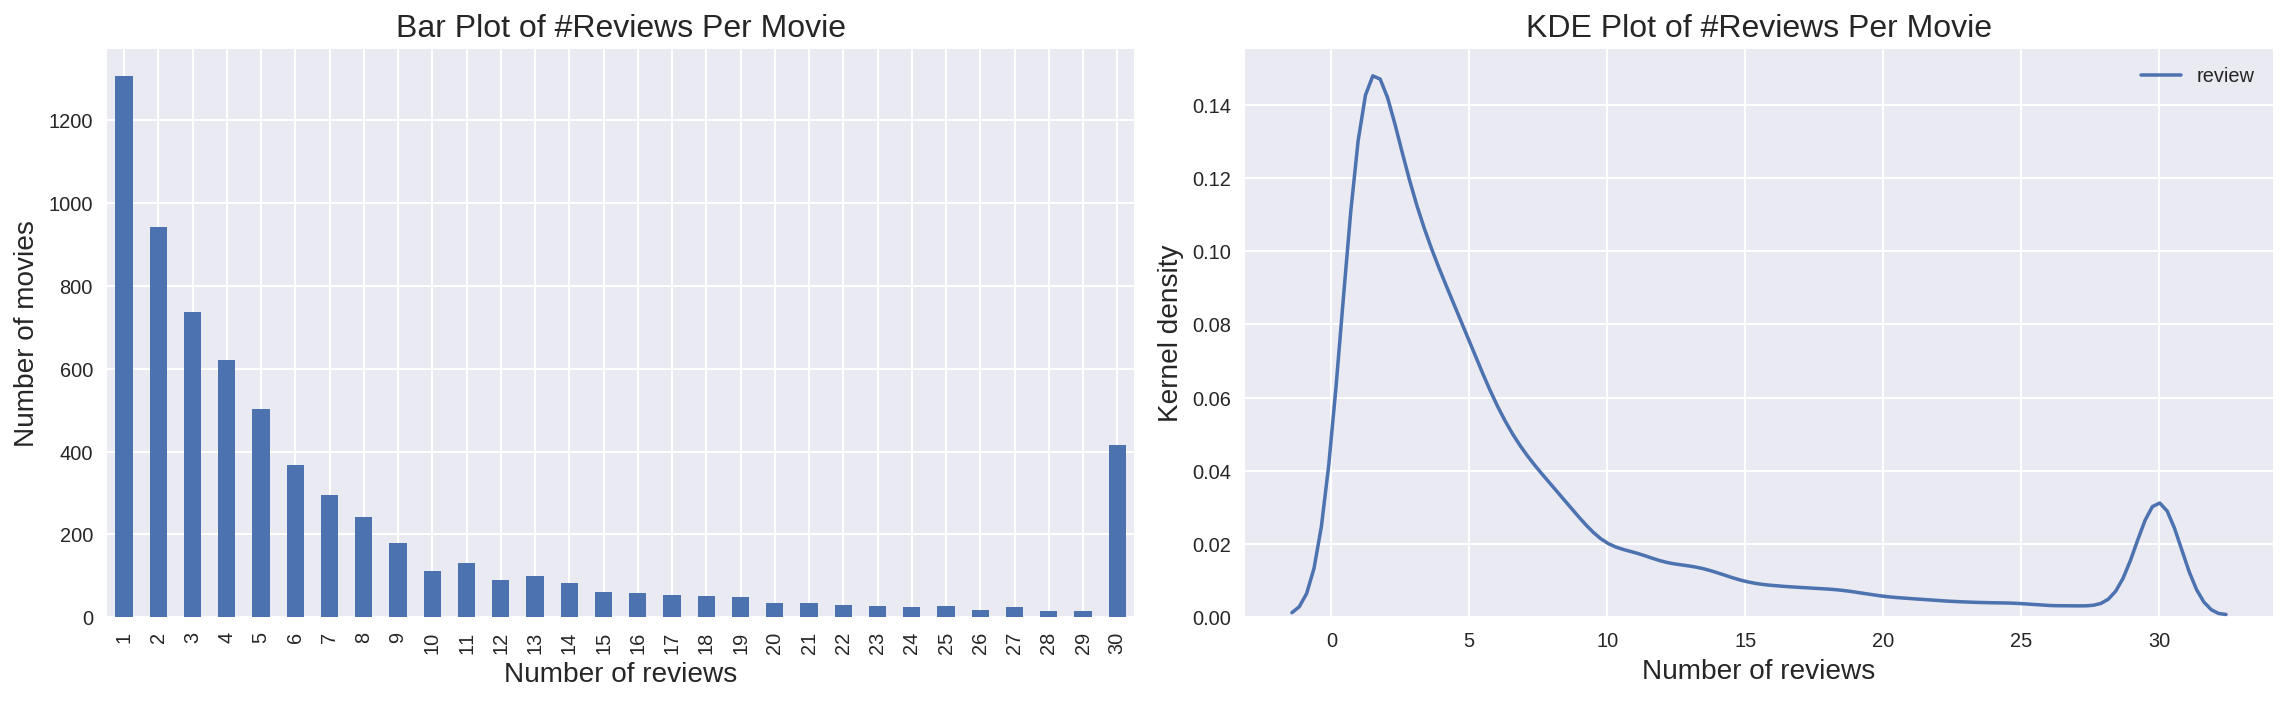

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie', fontsize=16)
ax.set_xlabel('Number of reviews', fontsize=14)
ax.set_ylabel('Number of movies', fontsize=14)

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie', fontsize=16)
ax.set_xlabel('Number of reviews', fontsize=14)
ax.set_ylabel('Kernel density', fontsize=14)

fig.tight_layout()

In [25]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Distribution of ratings:

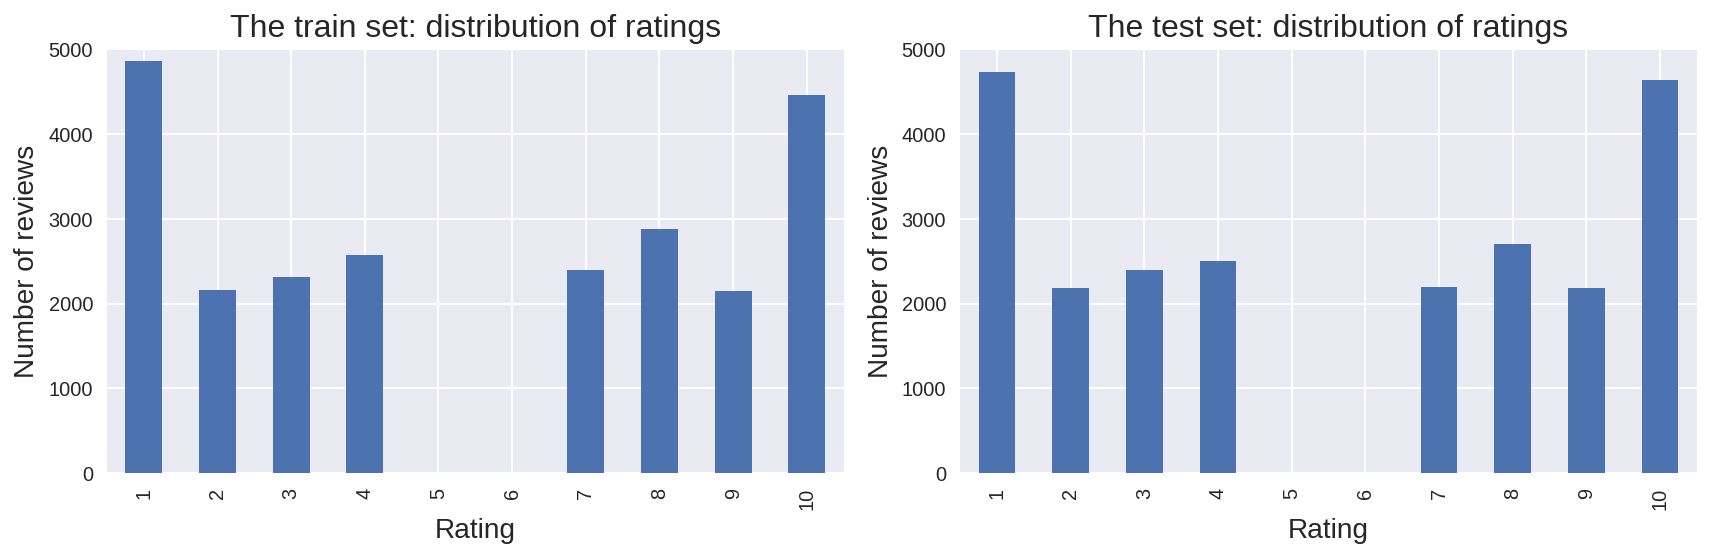

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings', fontsize=16)
ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings', fontsize=16)
ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

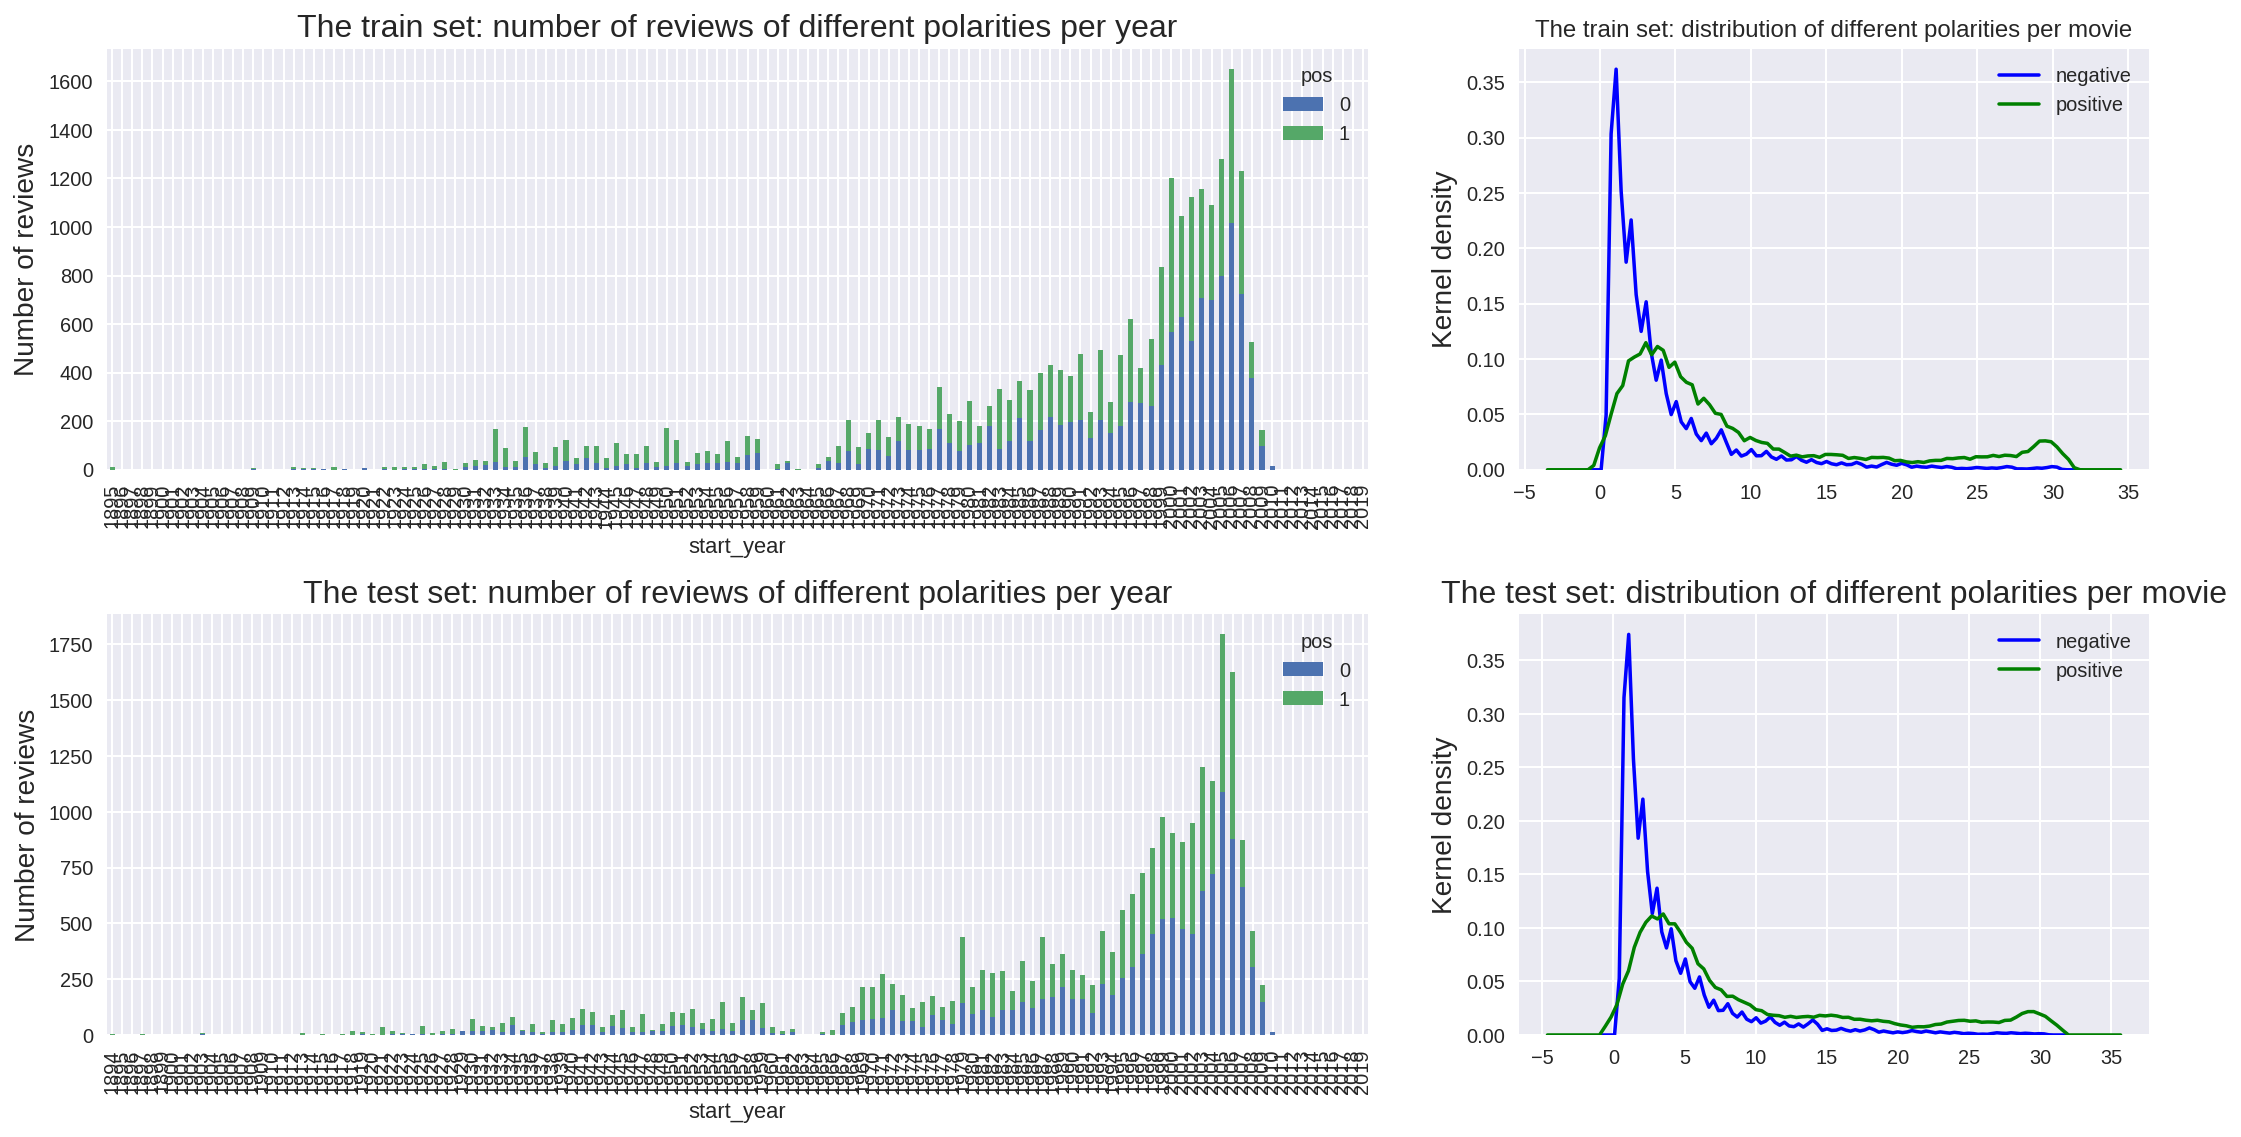

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year', fontsize=16)
ax.set_ylabel('Number of reviews', fontsize=14)
ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')
ax.set_ylabel('Kernel density', fontsize=14)
ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year', fontsize=16)
ax.set_ylabel('Number of reviews', fontsize=14)
ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie', fontsize=16)
ax.set_ylabel('Kernel density', fontsize=14)

fig.tight_layout()

The train and test sets are balanced and have similar distributions:

In [28]:
df_reviews.loc[df_reviews['ds_part']=='train','pos'].mean()

0.4994116658261893

In [29]:
df_reviews.loc[df_reviews['ds_part']=='test','pos'].mean()

0.4984489865295542

Genre effect on positivitey of reviews:

In [39]:
cols=df_reviews.columns[(pd.Series(df_reviews.columns).str.startswith('genre')) | (pd.Series(df_reviews.columns)=='pos') \
                       | (pd.Series(df_reviews.columns)=='ds_part')]

In [40]:
train_genre=df_reviews.loc[df_reviews['ds_part']=='train', cols].drop('ds_part',axis=1).groupby('pos').sum()

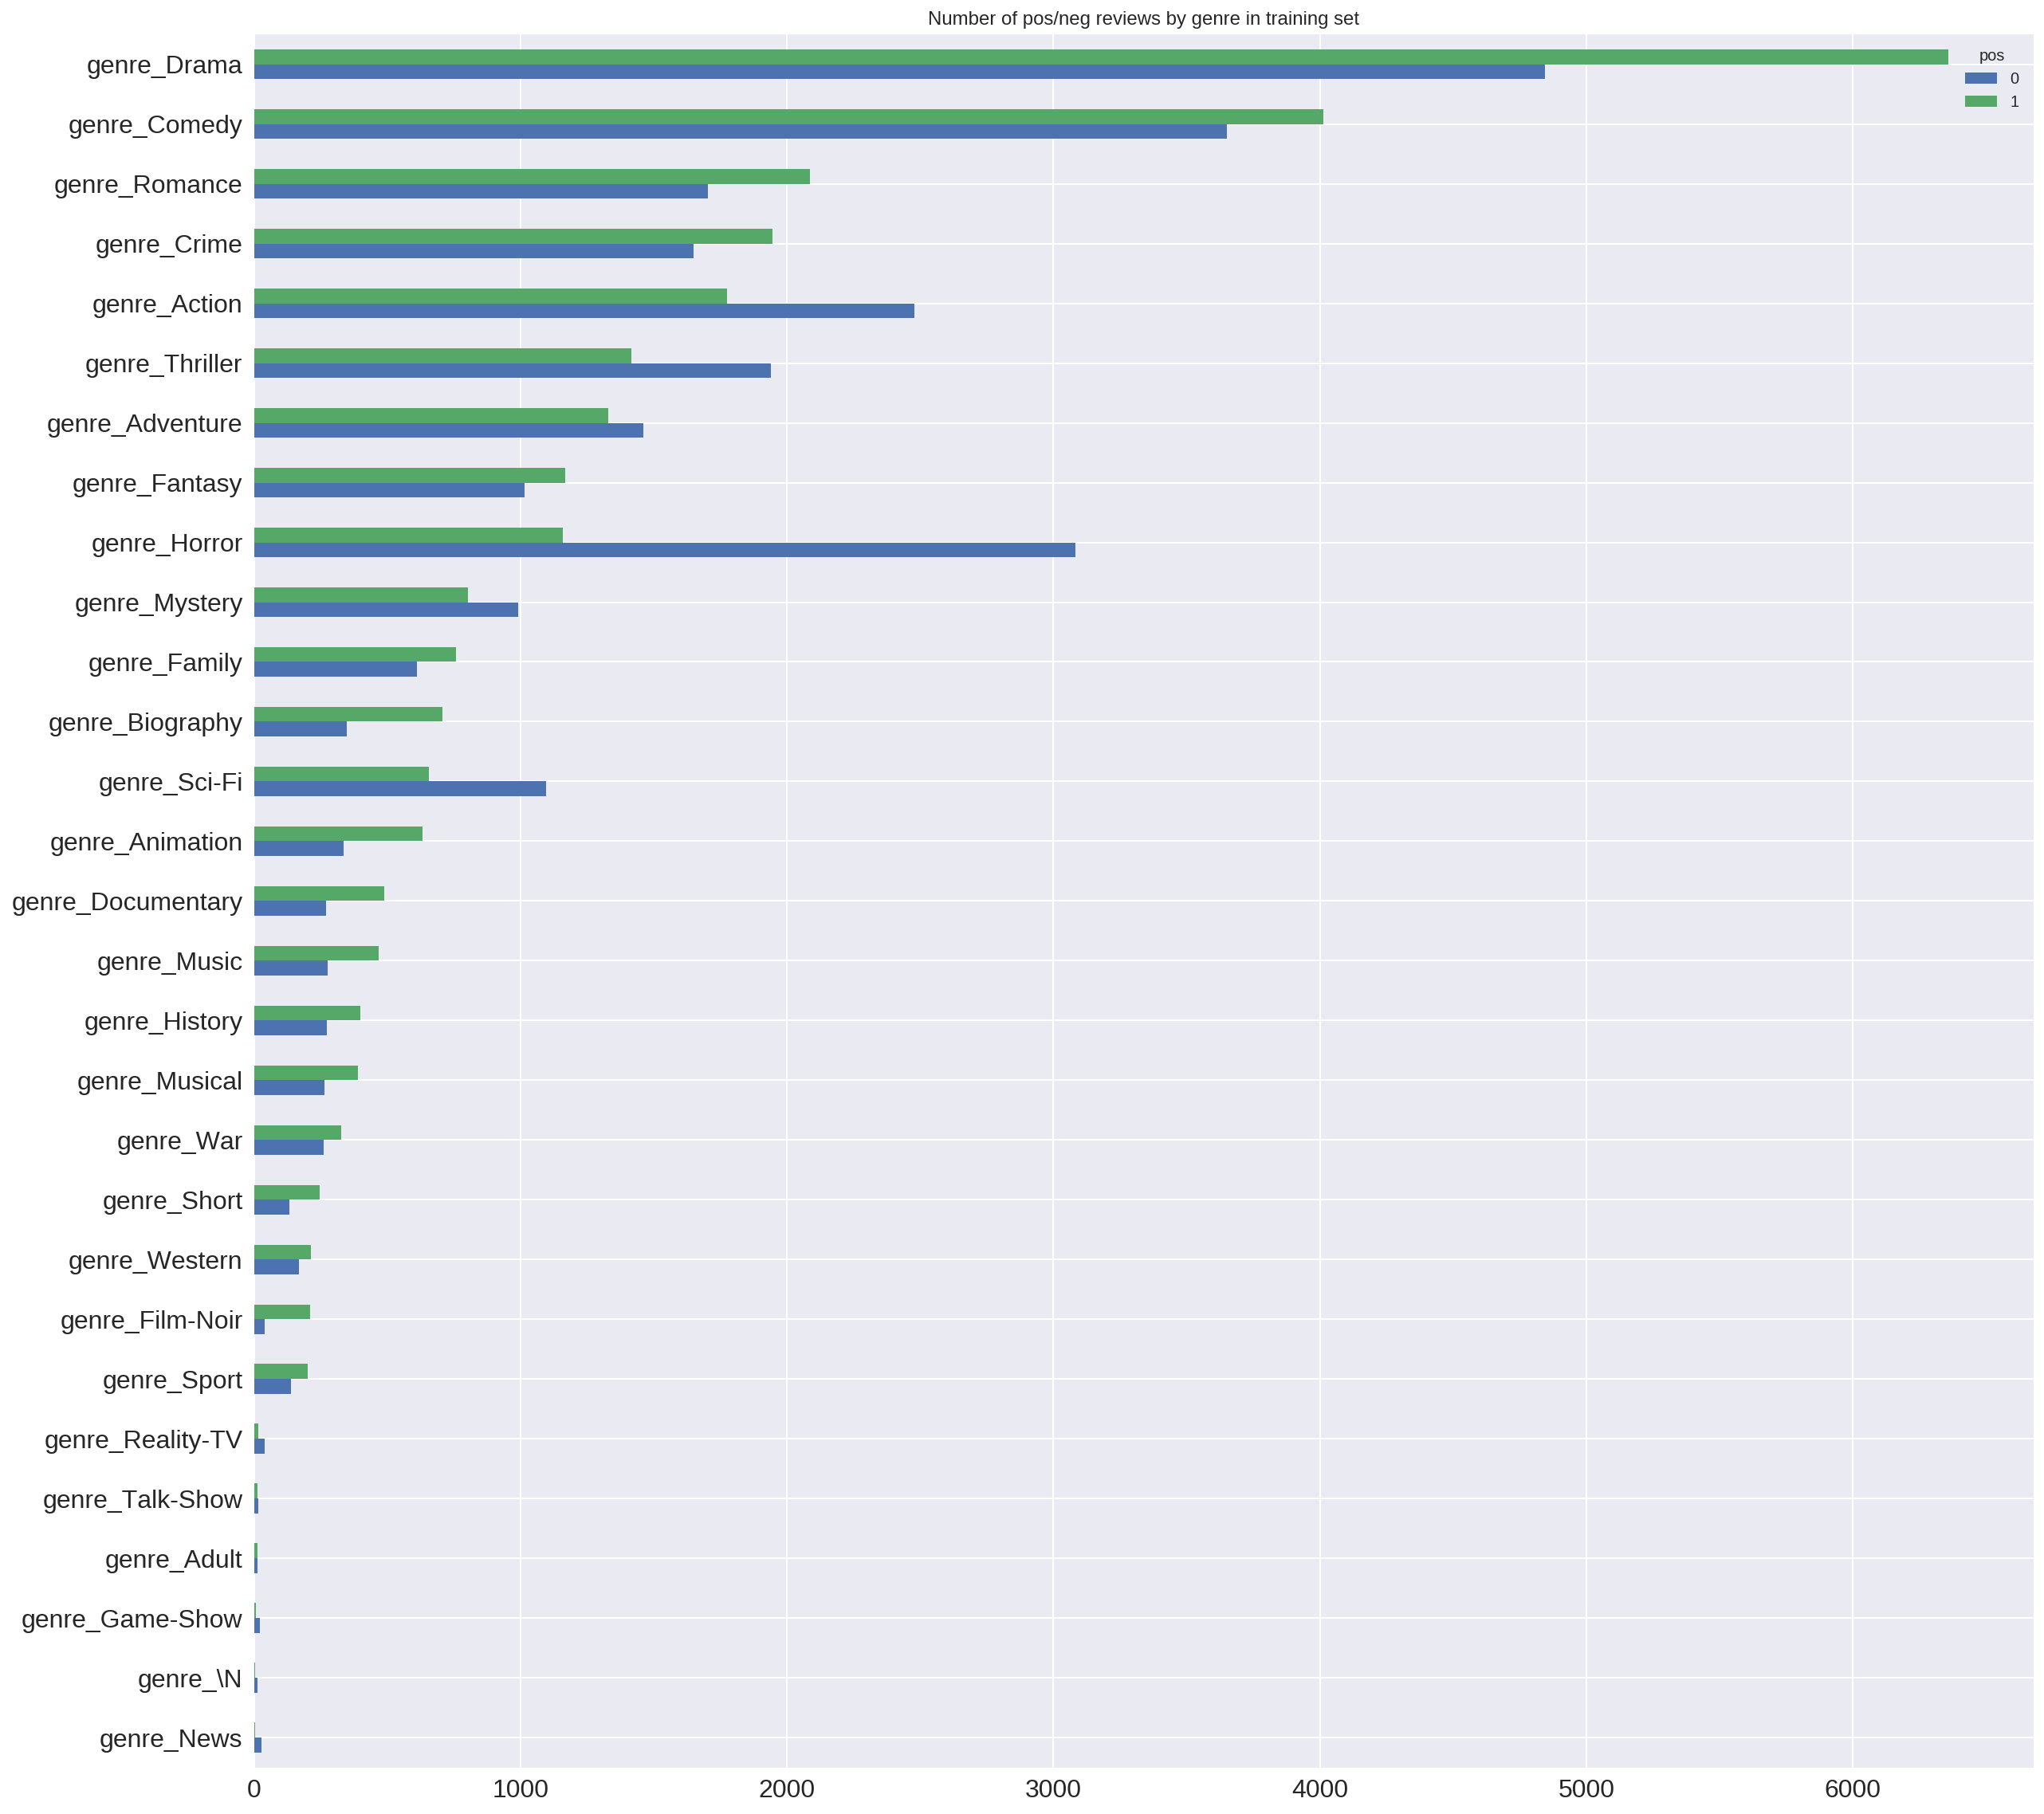

In [41]:
train_genre.sort_values(by=1, axis=1).T.plot.barh \
(figsize=(20,20), fontsize=16, title='Number of pos/neg reviews by genre in training set')

In [42]:
test_genre=df_reviews.loc[df_reviews['ds_part']=='test', cols].drop('ds_part',axis=1).groupby('pos').sum()

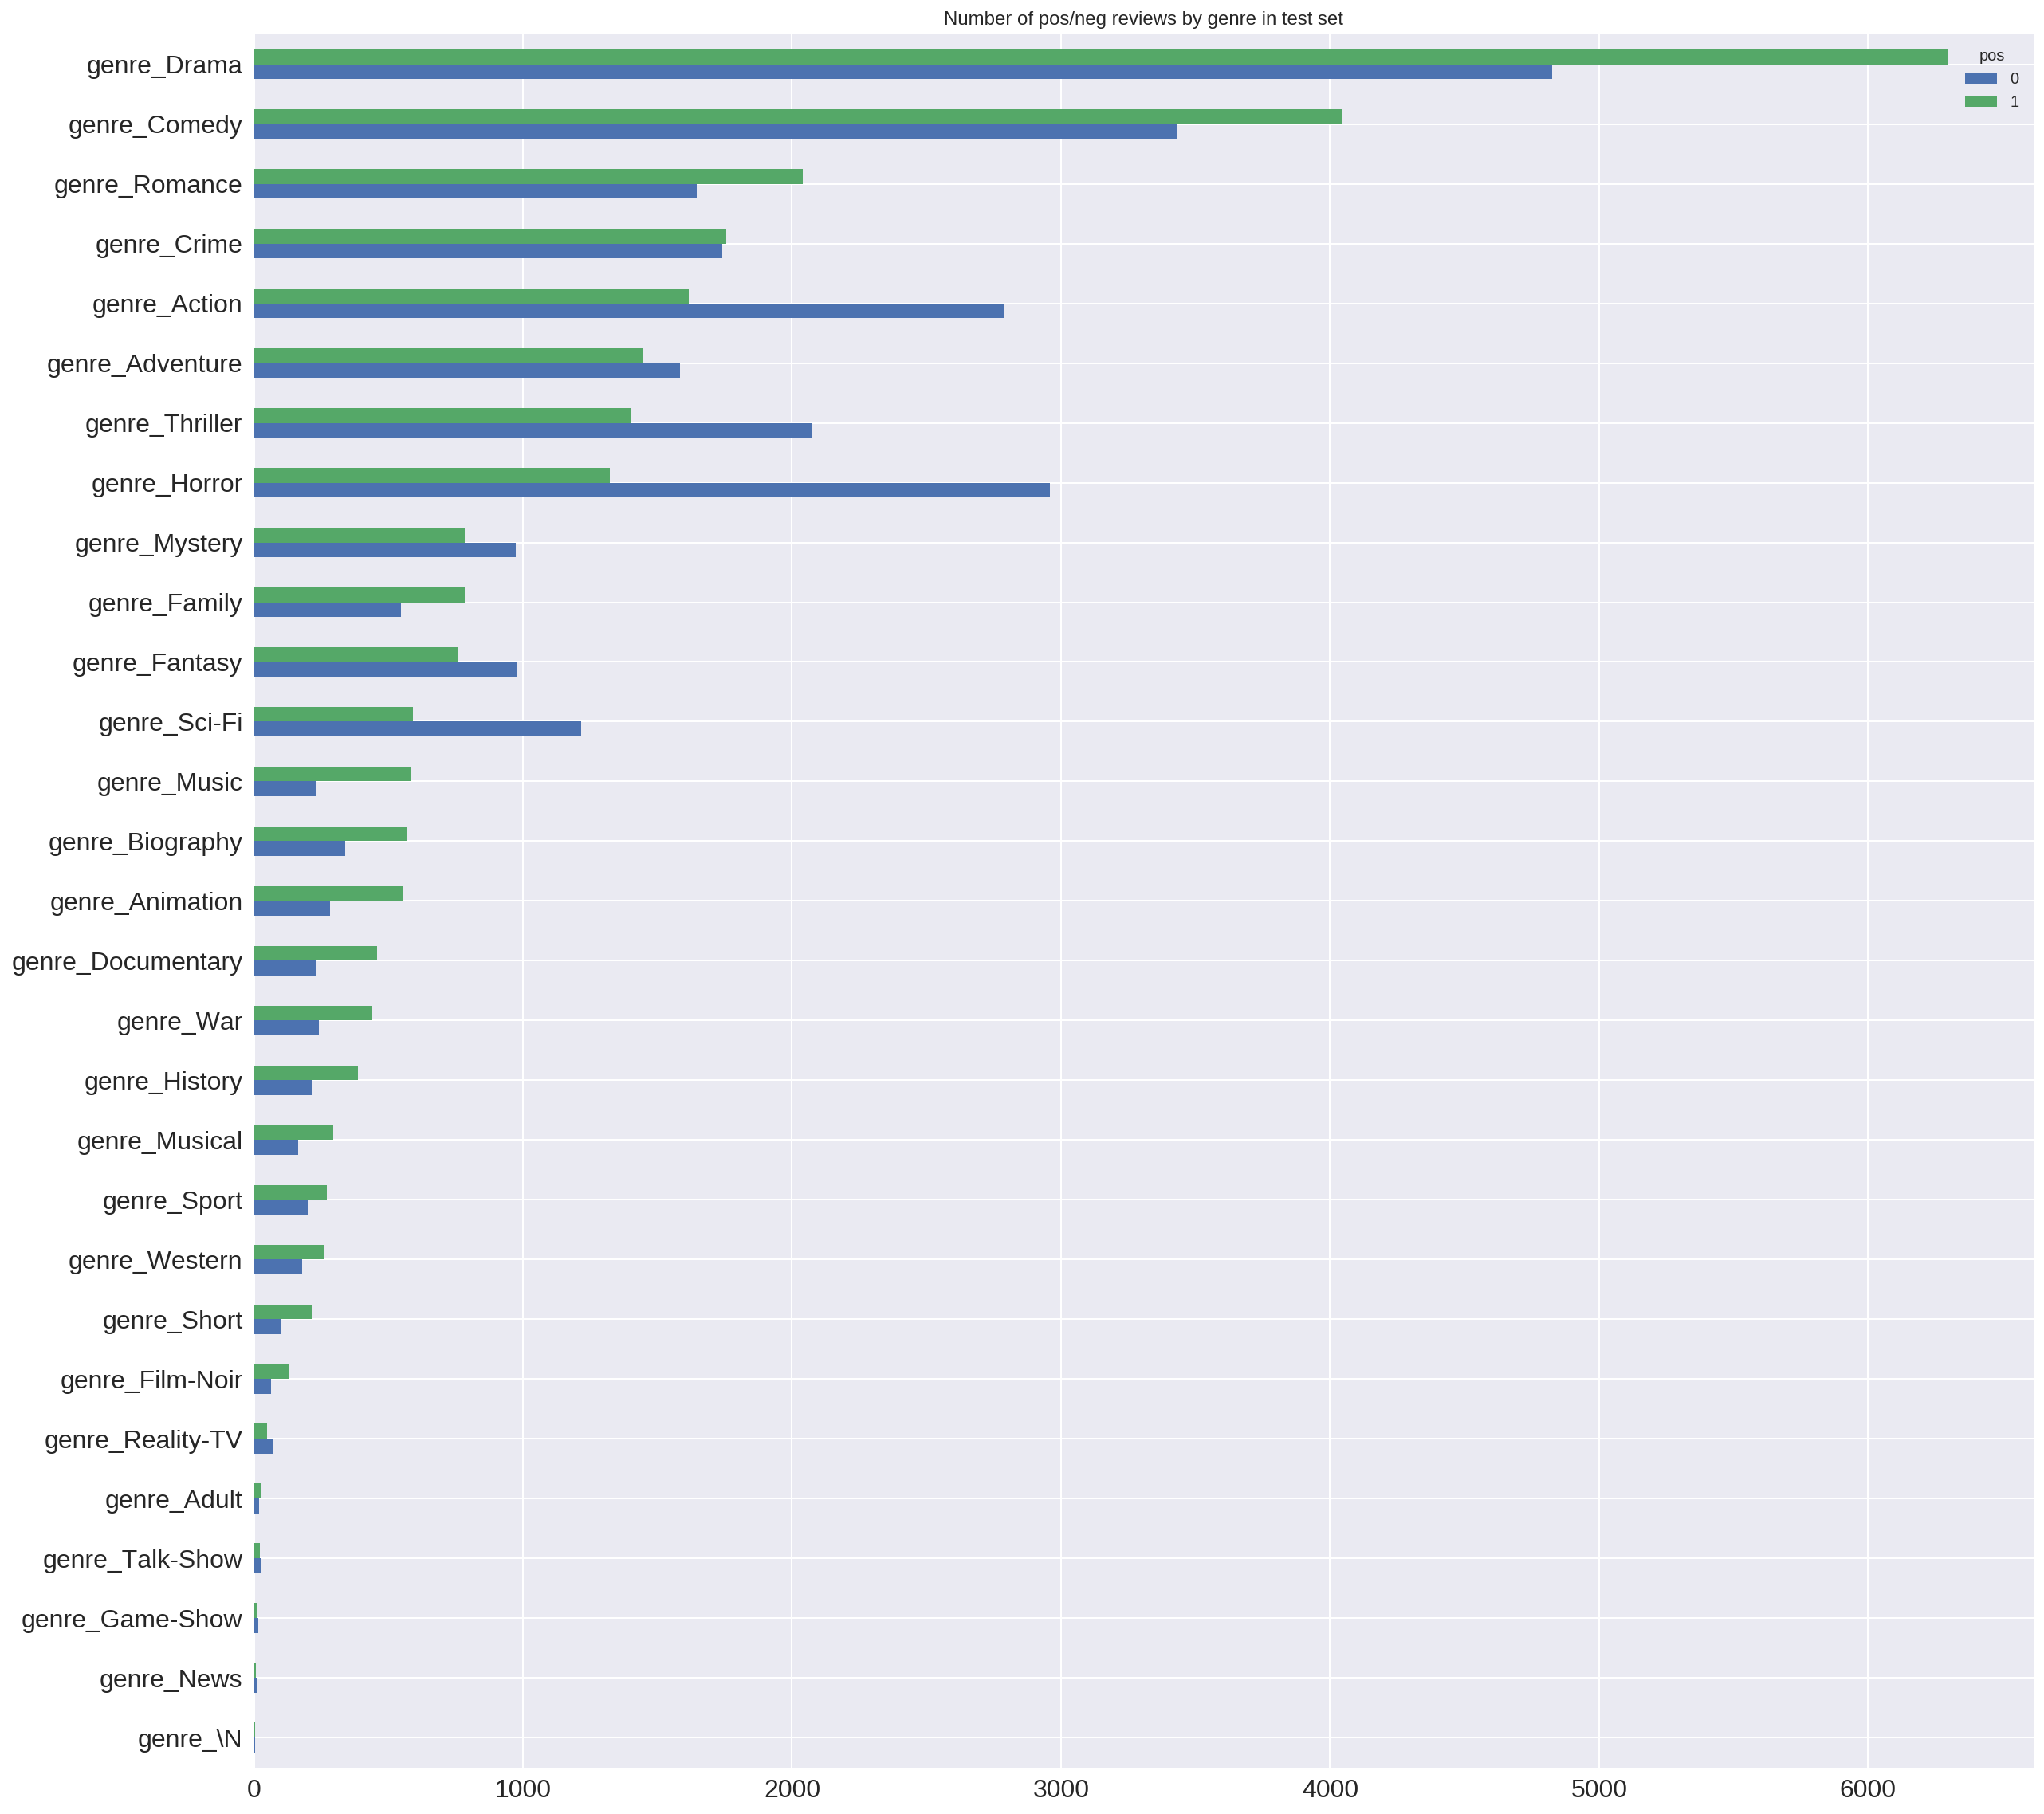

In [43]:
test_genre.sort_values(by=1, axis=1).T.plot.barh(figsize=(20,20), fontsize=16, title='Number of pos/neg reviews by genre in test set')

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [47]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [48]:
df_reviews['review_norm'] = df_reviews['review'].str.lower()

# Train / Test Split

In [49]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 44)
(23533, 44)


# Model 0 - Constant

The best constant guess in terms of F1 metric for a balanced set is 1:

Recall = Tp/(Tp+Fn) = 1

Precision = Tp/(Tp+Fp) = 0.5

F1 = 2/3 = 0.66

In [26]:
model_0 = DummyClassifier(strategy='constant', constant=1)

In [27]:
model_0.fit(df_reviews_train, train_target)

DummyClassifier(constant=1, random_state=None, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


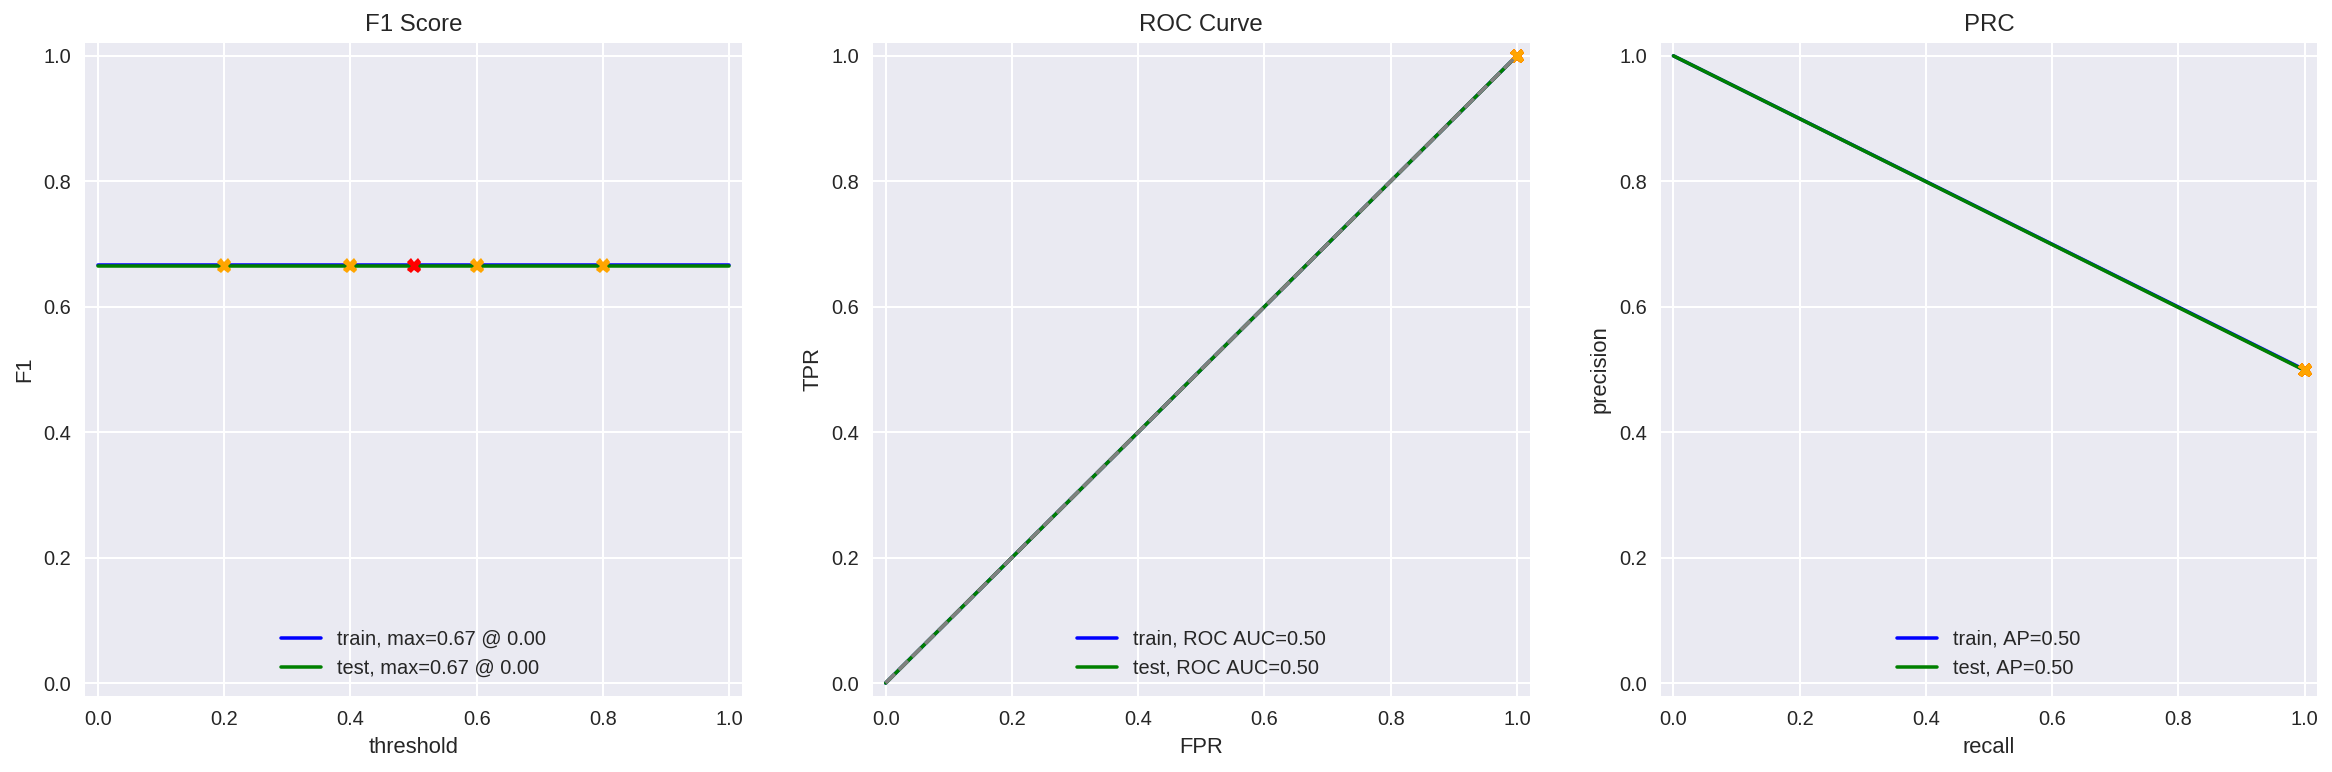

In [36]:
evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)

# Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [52]:
stop_words = set(stopwords.words('english'))
count_tf_idf_nltk = TfidfVectorizer(stop_words=stop_words) 

In [53]:
lemmatizer  = nltk.stem.WordNetLemmatizer() 
df_train_tokens_nltk = df_reviews_train['review'].apply((lambda x: nltk.tokenize.word_tokenize(x)))
df_train_lemmas_nltk = df_train_tokens_nltk.apply((lambda x:  ''.join([lemmatizer.lemmatize(token) for token in x])))


In [54]:
df_test_tokens_nltk = df_reviews_test['review'].apply((lambda x: nltk.tokenize.word_tokenize(x)))
df_test_lemmas_nltk = df_test_tokens_nltk.apply((lambda x:  ''.join([lemmatizer.lemmatize(token) for token in x]) ))

In [55]:
count_tf_idf_nltk.fit(df_train_lemmas_nltk)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [56]:
tf_idf_nltk_train = count_tf_idf_nltk.transform(df_train_lemmas_nltk)
tf_idf_nltk_test = count_tf_idf_nltk.transform(df_test_lemmas_nltk)

In [57]:
model_1 = LogisticRegression(solver='liblinear')

In [58]:
model_1.fit(tf_idf_nltk_train, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.99  0.69
F1         0.99  0.68
APS        1.00  0.74
ROC AUC    1.00  0.75


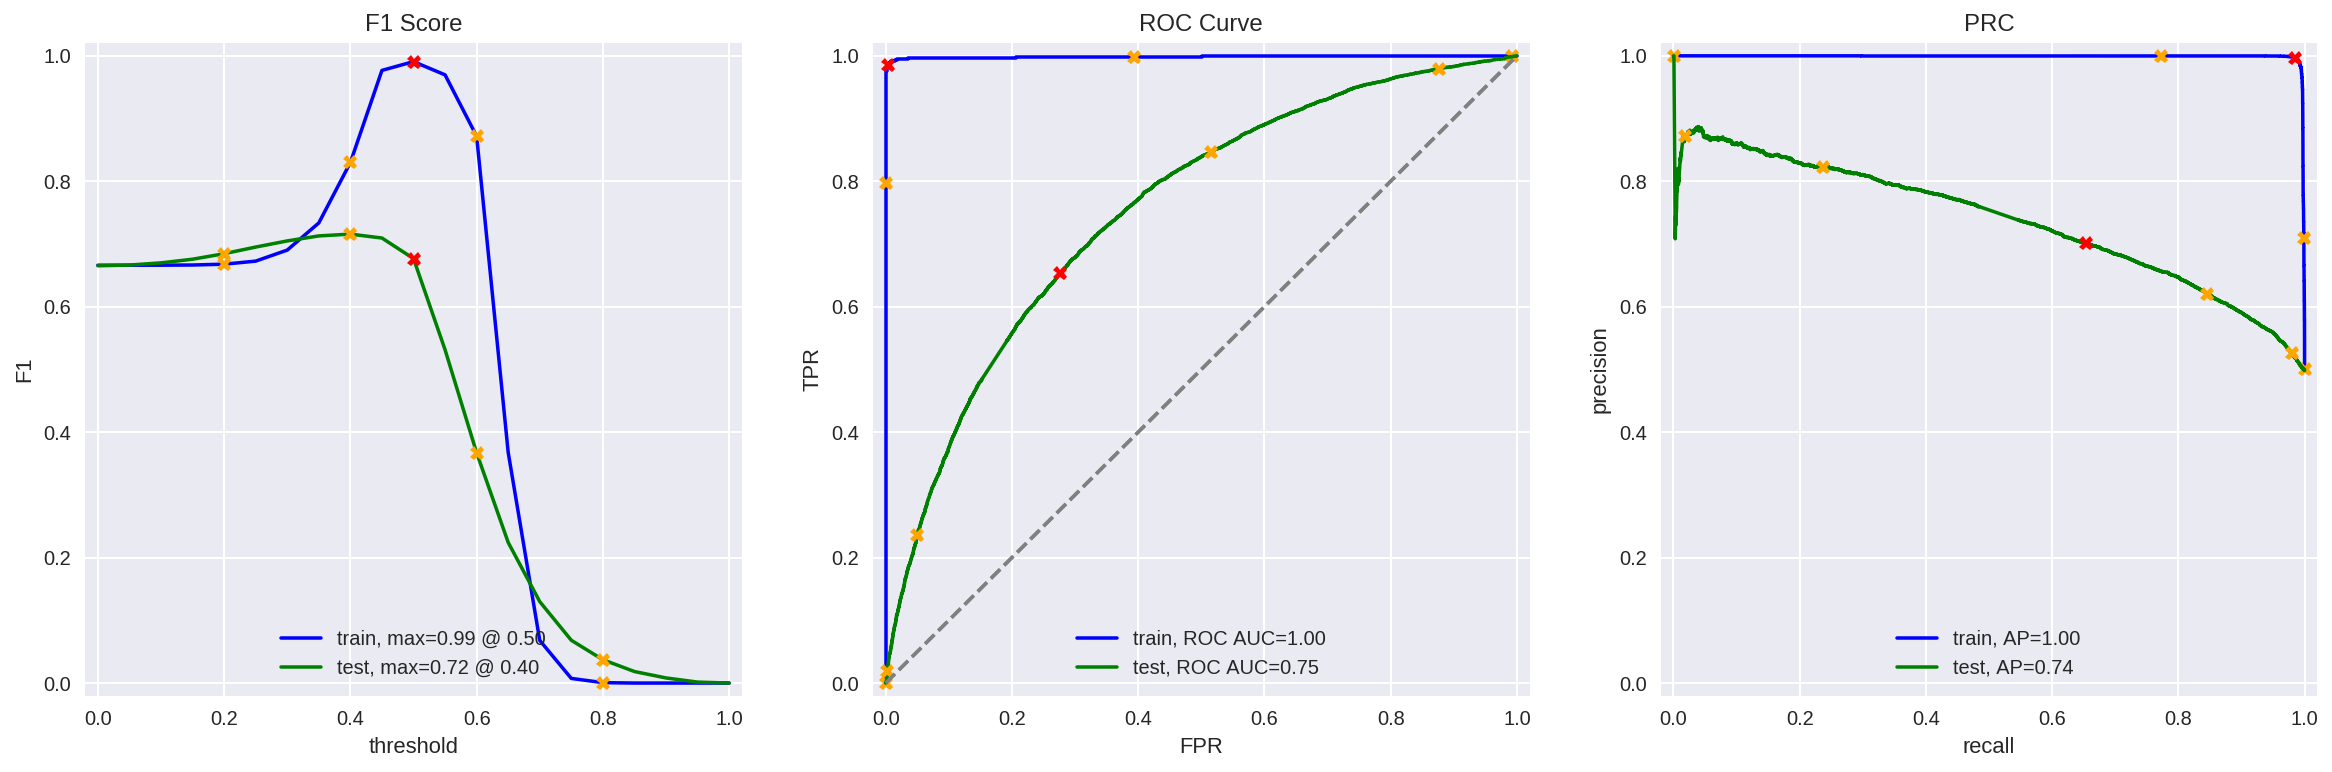

In [43]:
evaluate_model(model_1, tf_idf_train_nltk, train_target, tf_idf_test_nltk, test_target)

F1 score for test set is almost the same as for constant model. There's overfitting on train set. 

AUC ROC for test set improved from 0.5 to 0.75, acuuracy from 0.5 to 0.69.

# Model 2 - spaCy, TF-IDF and LR

In [63]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [68]:
def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = [token.lemma_ for token in doc]
    
    return ' '.join(lemmas)

In [69]:
count_tf_idf_spacy = TfidfVectorizer(stop_words=STOP_WORDS)

In [70]:
df_train_lemmas_spacy = df_reviews_train['review'].apply(text_preprocessing_2)
df_test_lemmas_spacy = df_reviews_test['review'].apply(text_preprocessing_2)

In [71]:
count_tf_idf_spacy.fit(df_train_lemmas_spacy)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another', 'any', ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [72]:
tf_idf_spacy_train = count_tf_idf_spacy.transform(df_train_lemmas_spacy)
tf_idf_spacy_test = count_tf_idf_spacy.transform(df_test_lemmas_spacy)

In [73]:
model_2 = LogisticRegression(solver='liblinear')

In [74]:
model_2.fit(tf_idf_spacy_train, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


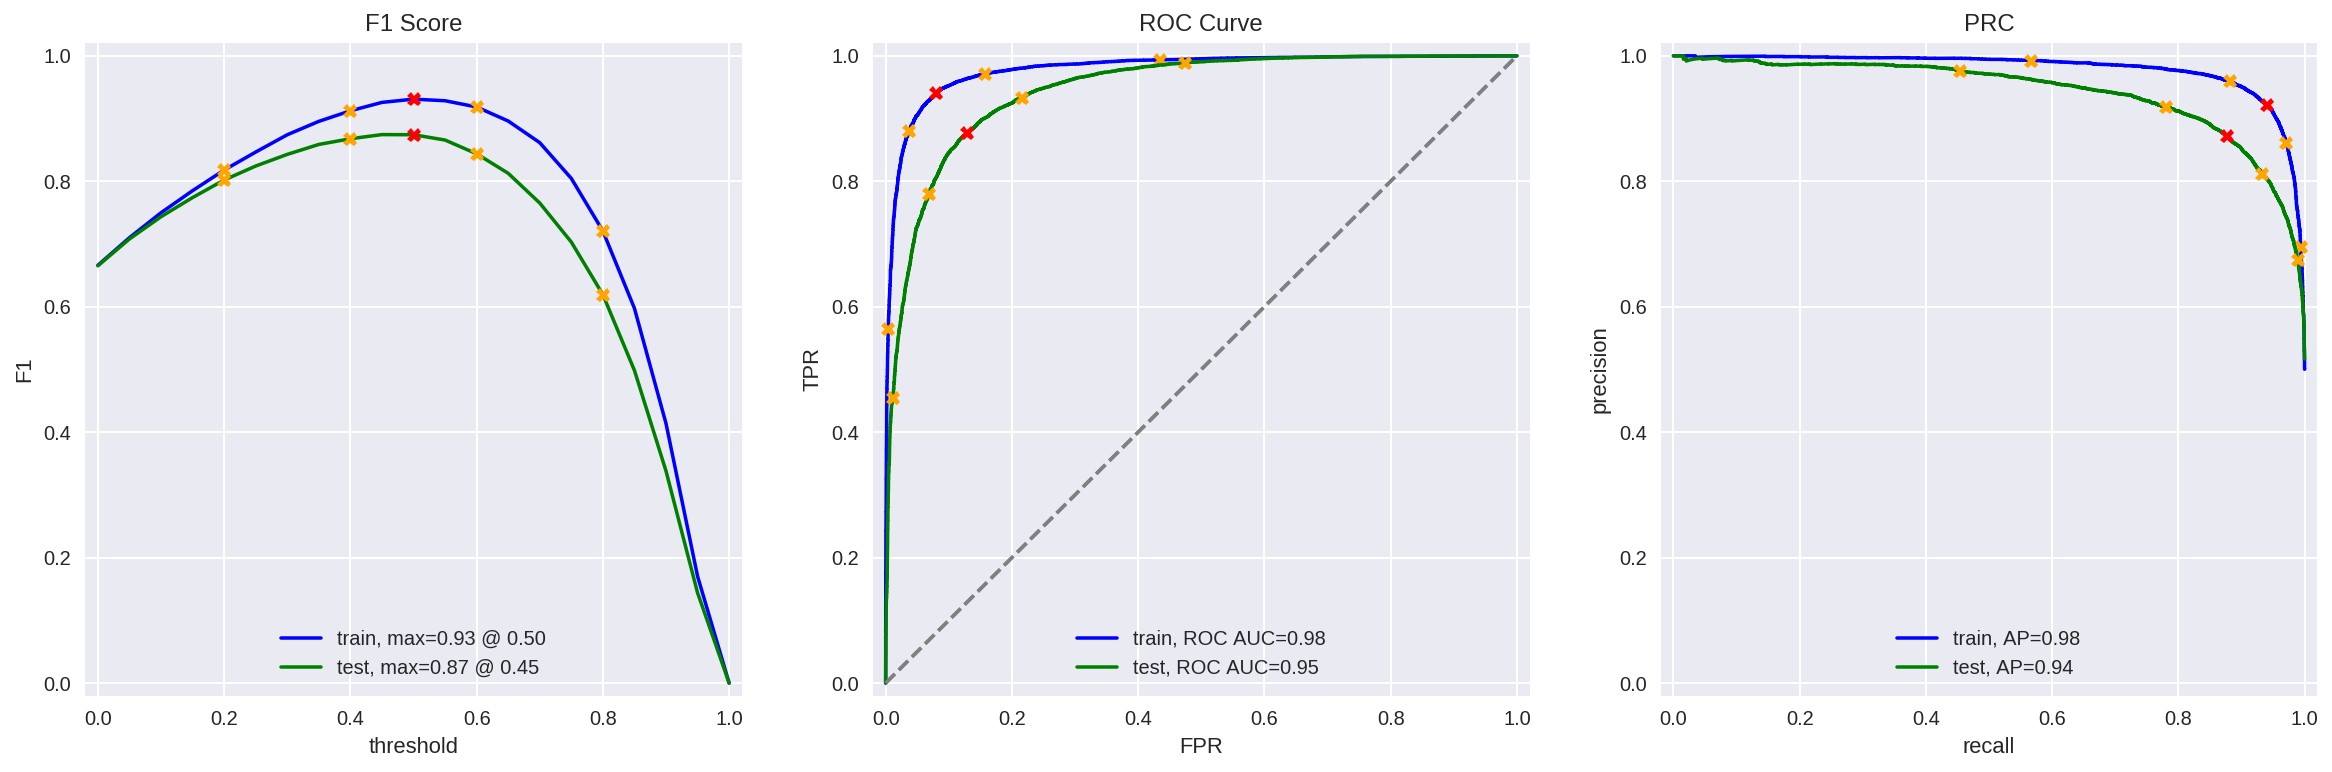

In [52]:
evaluate_model(model_2, tf_idf_spacy_train, train_target, tf_idf_spacy_test, test_target)

F1 score improved from 0.68 to 0.87, less overfitting.

AUC ROC improved from 0.75 to 0.95. Accuracy from 0.69 to 0.87.

# Model 3 - spaCy, TF-IDF and LGBMClassifier

The features for this model are the same as for model_3.

In [88]:
# def lgb_f1_score(data, y_pred):
#     y_true = data
#     y_hat = np.round(y_pred)
#     return 'f1', metrics.f1_score(y_true, y_hat), True

In [90]:
# LGBM_model = LGBMClassifier()
# #grid tuning hyper parameters
# grid = {'learning_rate': [0.03, 0.1, 0.5],
#         'num_leaves': [10, 20, 30, 40],
#         'n_estimators': [5, 10, 20, 50],
#        'random_state': [1234],
#        'objective': ["binary"],
#        'eval_metric': ['auc']}
#         #'eval_metric': [lgb_f1_score]}
# grid_search_result = GridSearchCV(LGBM_model, grid, scoring='f1', n_jobs=-1,cv=3)
# grid_search_result.fit(tf_idf_spacy_train, train_target,feature_name='auto')

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_ra

In [91]:
# grid_search_result.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.5,
 'n_estimators': 50,
 'num_leaves': 30,
 'objective': 'binary',
 'random_state': 1234}

In [77]:
model_3 = LGBMClassifier(learning_rate=0.5,num_leaves=30, n_estimators=50,random_state=1234,objective='binary', eval_metric='auc')
model_3.fit(tf_idf_spacy_train, train_target,feature_name='auto')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.5,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=30,
               objective='binary', random_state=1234, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.92
ROC AUC    0.99  0.93


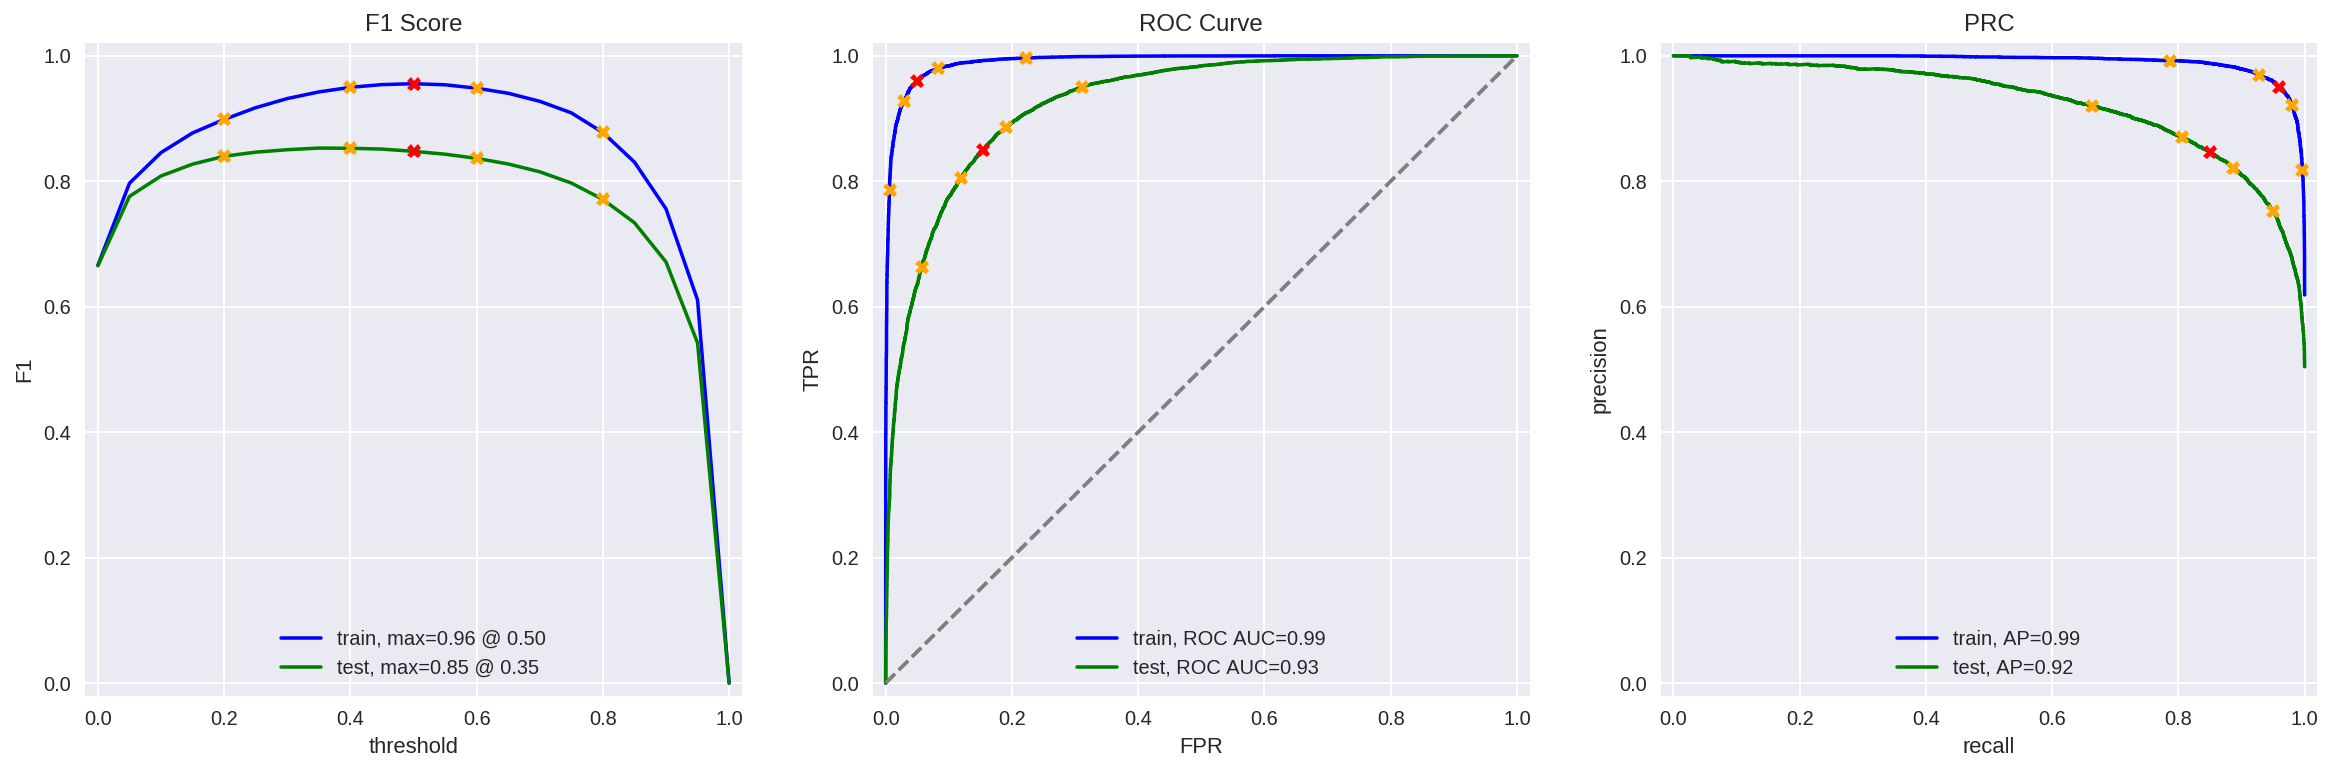

In [95]:
evaluate_model(model_3, tf_idf_spacy_train, train_target, tf_idf_spacy_test, test_target)

The results for spacy with lightGBM are a little less than the results with spacy and LR. There is some overfitting as the results fot the training set are much better.

# Model 4 - spaCy, TF-IDF and CatBoost

In [47]:
# CB_model =CatBoostClassifier()

# #grid tuning hyper parameters
# grid = {'learning_rate': [0.5],
#         'depth': [4, 6],
#         'iterations': [10, 50],
#        'l2_leaf_reg': [2,4],
#        'eval_metric': ['F1'],
#        'objective': ['Logloss']}

# grid_search_result = GridSearchCV(CB_model, grid, scoring='f1', n_jobs=-1,cv=3)
# grid_search_result.fit(tf_idf_spacy_train, train_target)

0:	learn: 0.7425795	total: 1.03s	remaining: 9.28s
1:	learn: 0.7504180	total: 1.93s	remaining: 7.73s
2:	learn: 0.7607973	total: 2.83s	remaining: 6.61s
3:	learn: 0.7726887	total: 3.73s	remaining: 5.6s
4:	learn: 0.7741191	total: 4.73s	remaining: 4.73s
5:	learn: 0.7782910	total: 5.63s	remaining: 3.75s
6:	learn: 0.7853305	total: 6.53s	remaining: 2.8s
7:	learn: 0.7895838	total: 7.42s	remaining: 1.86s
8:	learn: 0.7932267	total: 8.42s	remaining: 935ms
9:	learn: 0.7957319	total: 9.32s	remaining: 0us
0:	learn: 0.7427283	total: 1.11s	remaining: 9.98s
1:	learn: 0.7526359	total: 2.01s	remaining: 8.05s
2:	learn: 0.7644002	total: 2.91s	remaining: 6.79s
3:	learn: 0.7748573	total: 3.81s	remaining: 5.72s
4:	learn: 0.7823102	total: 4.81s	remaining: 4.81s
5:	learn: 0.7878264	total: 5.71s	remaining: 3.81s
6:	learn: 0.7939091	total: 6.71s	remaining: 2.87s
7:	learn: 0.7981942	total: 7.71s	remaining: 1.93s
8:	learn: 0.8000707	total: 8.61s	remaining: 957ms
9:	learn: 0.8042654	total: 9.6s	remaining: 0us
0:	lear

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f08e99d3b10>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [4, 6], 'eval_metric': ['F1'],
                         'iterations': [10, 50], 'l2_leaf_reg': [2, 4],
                         'learning_rate': [0.5], 'objective': ['Logloss']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [48]:
# grid_search_result.best_params_

{'depth': 6,
 'eval_metric': 'F1',
 'iterations': 50,
 'l2_leaf_reg': 4,
 'learning_rate': 0.5,
 'objective': 'Logloss'}

In [78]:
model_4 = CatBoostClassifier(depth= 6, eval_metric= 'F1', iterations= 50, l2_leaf_reg= 4, learning_rate= 0.5, \
 objective= 'Logloss')

In [79]:
model_4.fit(tf_idf_spacy_train, train_target)

0:	learn: 0.7494895	total: 3.7s	remaining: 3m 1s
1:	learn: 0.7647037	total: 6.59s	remaining: 2m 38s
2:	learn: 0.7765917	total: 9.4s	remaining: 2m 27s
3:	learn: 0.7822719	total: 12.3s	remaining: 2m 21s
4:	learn: 0.7896458	total: 15.2s	remaining: 2m 16s
5:	learn: 0.7954491	total: 18.1s	remaining: 2m 12s
6:	learn: 0.8007752	total: 21.1s	remaining: 2m 9s
7:	learn: 0.8062022	total: 24.1s	remaining: 2m 6s
8:	learn: 0.8097865	total: 27s	remaining: 2m 2s
9:	learn: 0.8140631	total: 29.9s	remaining: 1m 59s
10:	learn: 0.8183895	total: 32.7s	remaining: 1m 55s
11:	learn: 0.8207043	total: 35.6s	remaining: 1m 52s
12:	learn: 0.8240972	total: 38.6s	remaining: 1m 49s
13:	learn: 0.8265606	total: 41.6s	remaining: 1m 46s
14:	learn: 0.8284876	total: 44.6s	remaining: 1m 44s
15:	learn: 0.8304593	total: 47.6s	remaining: 1m 41s
16:	learn: 0.8320826	total: 50.6s	remaining: 1m 38s
17:	learn: 0.8329562	total: 53.5s	remaining: 1m 35s
18:	learn: 0.8342030	total: 56.5s	remaining: 1m 32s
19:	learn: 0.8366744	total: 59

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.88  0.85
F1         0.88  0.85
APS        0.95  0.92
ROC AUC    0.95  0.92


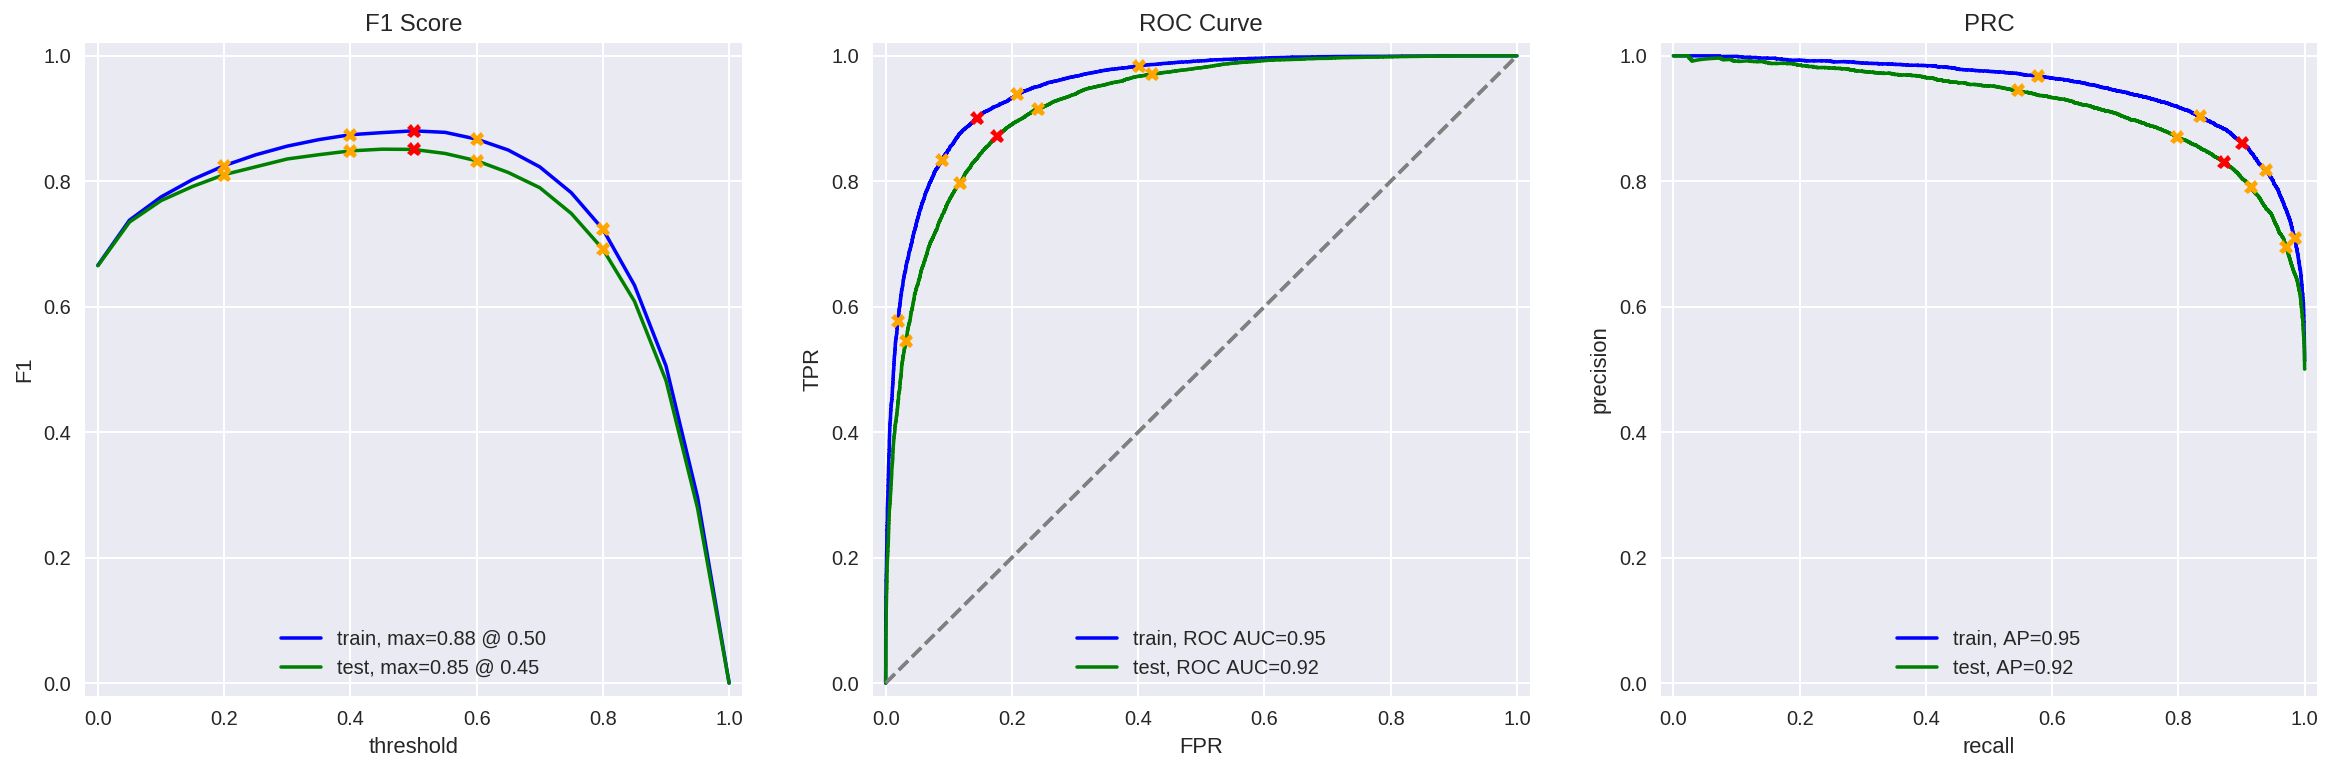

In [51]:
evaluate_model(model_4, tf_idf_spacy_train, train_target, tf_idf_spacy_test, test_target)

The results for test set are similar to those with LightGBM, but here we have much less overfitting.

# My Reviews

In [50]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","i did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","well, i was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good! writ...
5,"The movie had its upsides and downsides, but I...","the movie had its upsides and downsides, but i..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy. not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move & i real...


In [126]:
#storing the pos / neg classification of the reviews for later comparison
my_reviews_results = {}
true = [0, 0, 1, 0, 1, 1, 0, 1]
my_reviews_results['True'] = ['True']+list(true)

# Model 1

In [90]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_1 = model_1.predict_proba(count_tf_idf_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}:  {review}')

0.23:  i did not simply like it, not my kind of movie.
0.24:  well, i was bored and felt asleep in the middle of the movie.
0.11:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.41:  i didn't expect the reboot to be so good! writers really cared about the source material
0.53:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.34:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.48:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


In [136]:
prob=(np.around(my_reviews_pred_prob_1,2))
my_reviews_results['Model_1'] = ['NLTK, TF-IDF, LR'] + list(prob)
my_reviews_results['Model_1_correct'] = [np.nan]+  list(((prob+true-0.5)<0) | ((prob+true-0.5)>1))

## Model 2

In [92]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_2 = model_2.predict_proba(count_tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.18:  i did not simply like it, not my kind of movie.
0.06:  well, i was bored and felt asleep in the middle of the movie.
0.47:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.21:  i didn't expect the reboot to be so good! writers really cared about the source material
0.48:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.02:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.91:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


In [138]:
prob=(np.around(my_reviews_pred_prob_2,2))
my_reviews_results['Model_2'] = ['spaCy, TF-IDF, LR'] + list(prob)
my_reviews_results['Model_2_correct'] = [np.nan]+  list(((prob+true-0.5)<0) | ((prob+true-0.5)>1))

### Model 3

In [94]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_3 = model_3.predict_proba(count_tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.51:  i did not simply like it, not my kind of movie.
0.16:  well, i was bored and felt asleep in the middle of the movie.
0.58:  i was really fascinated with the movie
0.23:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.46:  i didn't expect the reboot to be so good! writers really cared about the source material
0.47:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.05:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.92:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


In [139]:
prob=(np.around(my_reviews_pred_prob_3,2))
my_reviews_results['Model_3'] = ['spaCy, TF-IDF, LGBM'] + list(prob)
my_reviews_results['Model_3_correct'] = [np.nan]+  list(((prob+true-0.5)<0) | ((prob+true-0.5)>1))

# Model 4

In [97]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_4 = model_4.predict_proba(count_tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.58:  i did not simply like it, not my kind of movie.
0.29:  well, i was bored and felt asleep in the middle of the movie.
0.57:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.54:  i didn't expect the reboot to be so good! writers really cared about the source material
0.51:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.28:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.74:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


In [140]:
prob=(np.around(my_reviews_pred_prob_4,2))
my_reviews_results['Model_4'] = ['spaCy, TF-IDF, CB'] + list(prob)
my_reviews_results['Model_4_correct'] = [np.nan]+  list(((prob+true-0.5)<0) | ((prob+true-0.5)>1))

# Conclusions

Comparing models performance on test set:

0. Constant model: F1=0.67, ROC AUC = 0.5

1. NLTK with LR performed the worst on test set comparing to other non constant models, but performed the best on the training set, which means there's a significant overfitting. F1=0.68, ROC AUC = 0.75

2. spaCy with LR performed the best on the test set with very little overfitting F1=0.87, ROC AUC = 0.95

3. spaCy with LGBM performed only a little wotse than LR on test set but with much significant overfitting. F1=0.85, AUC ROC=0.92

4. spaCy with CB performed the same as LGBM but with much less overfitting. F1=0.85, AUC ROC=0.92

Comparing models performance on my reviews:

In [141]:
index=['Model', 'rev_0', 'rev_1', 'rev_2', 'rev_3', 'rev_4', 'rev_5', 'rev_6', 'rev_7']
res = pd.DataFrame(my_reviews_results, index=index)
res

,True,Model_1,Model_1_correct,Model_2,Model_2_correct,Model_3,Model_3_correct,Model_4,Model_4_correct
Model,True,"NLTK, TF-IDF, LR",NaN,"spaCy, TF-IDF, LR",NaN,"spaCy, TF-IDF, LGBM",NaN,"spaCy, TF-IDF, CB",NaN
rev_0,0,0.23,True,0.18,True,0.51,False,0.58,False
rev_1,0,0.24,True,0.06,True,0.16,True,0.29,True
rev_2,1,0.11,False,0.47,False,0.58,True,0.57,True
rev_3,0,0.19,True,0.13,True,0.23,True,0.48,True
rev_4,1,0.41,False,0.21,False,0.46,False,0.54,True
rev_5,1,0.53,True,0.48,False,0.47,False,0.51,True
rev_6,0,0.34,True,0.02,True,0.05,True,0.28,True
rev_7,1,0.48,False,0.91,True,0.92,True,0.74,True


- When taking the classification threshold to be 0.5 the CatBoost model performs the best, which is reasonable since in had it's F1 maximum at thresh=0.45 and had the smallest overfitting. 

- Linear regression models wrongly classified Fp but with no Fn so they only lower precision.

- Lowering the threshold to around 0.4 would make the all other three models perform better than CB.